## Strategy

Calculate which places vote less than average. Then of those, figure out which one, if they increase their participation to the average, would yield a net increase in votes to the designated party. Esentially which places would grant an extra electoral seat whith a non-partisan democratic message of more participation.


## Hypothesis

1. The distribution of votes within a region doesn´t change with participation rates increases towards the average. I.e. if 30% of the people in that region vote for party X when the participation is 20%, they will still vote 30% to that party when the participation incerases to 30%.

2. We use a single electoral college or circumscription, as it the case for Spain and the European elections. I.e. every vote count the same, and the seats are assignes using the D´Hont law.

Note: To improve it, one could assume a partisan message, and then assign the effort to increase the % of votes for a particular vote using the analogy of saturation points. I.e. look at change of prevalence as a proxy of effort to make that change.

## Data

* I use the latest most granular data available for Spain 2014 european elections. 

* The data is available online at http://elecciones.mir.es/resultados2014/ini99v.htm Note: They are "provisional to 99.77% but these are the best ones I could get at the municipal granularity. 

* One could modify votes using more recent trends, but for the scope of this exercise, this is enough.

The data is not available in a standard format, rather is an internal file inside the executable program the goverment created. One has to figet a bit extract the `.mdb` database of 132 Mb. 

To extract the data I use the hins given here: https://www.codeenigma.com/community/blog/using-mdbtools-nix-convert-microsoft-access-mysql

```sql
mdb-schema Europeas2014.mdb mysql > schema.sql
mkdir sql
for i in $( mdb-tables Europeas2014.mdb ); do echo $i ; mdb-export -D "%Y-%m-%d %H:%M:%S" -H -I mysql Europeas2014.mdb $i > sql/$i.sql; done
mysql -uroot -ppassword europeas < schema.sql
for i in $( ls sql/ ); do echo $i ; mysql -uroot -ppassword europeas < sql/$i ; done
```


In [1]:
def init():
    %matplotlib inline
    global os,pymysql,pd
    import os
    import pymysql
    import pandas as pd
    
    global conn
    host = os.getenv('MYSQL_HOST')
    port = os.getenv('MYSQL_PORT')
    user = os.getenv('MYSQL_USER')
    password = os.getenv('MYSQL_PASSWORD')
    database = 'europeas'    
    
    conn = pymysql.connect(
    host=host,
    port=int(port),
    user=user,
    passwd=password,
    db=database,
    charset='utf8mb4')

init()

In [2]:
#test connection
query="select * from resultados limit 1"
df = pd.read_sql_query(query,conn)
df.to_dict('index')

{0: {'CLAVE': 0,
  'CANDIDATURA': '0002',
  'AUTONOMIA': '00',
  'PROVINCIA': '00',
  'COMARCA': '00',
  'MUNICIPIO': '000',
  'DISTRITO': '00',
  'TRAMO': '0',
  'VOTOS_ACT': 33826,
  'PVOTOS_ACT': 0.21,
  'VOTOS_ANT': 0,
  'PVOTOS_ANT': 0.0,
  'ESCA_ACT': 0,
  'ESCA_ANT': 0,
  'GANADOR_ACT': 0,
  'GANADOR_ANT': 0,
  'AGR_PROVINCIAL': '0002',
  'AGR_AUTONOMICA': '0002',
  'AGR_ESTATAL': '0002',
  'COLOR': 1,
  'EXISTE': 'S',
  'ES_ANTERIOR': 'N',
  'ES_ACTUAL': 'S'}}

This means the party names are abstracted into a dictionary. To see e.g. what is the `CANDIDATURA: 0002`


In [3]:
query="select * from candidaturas where candidatura=0002;"
df = pd.read_sql_query(query,conn)
df.to_dict('index')


{0: {'CANDIDATURA': '0002',
  'SIGLA': 'F.A.C.',
  'DENOMINACION': 'FORO DE CIUDADANOS',
  'Color': 1,
  'Rojo': 31,
  'Verde': 73,
  'Azul': 125,
  'AGR_ESTATAL': '0002',
  'AGR_AUTONOMICA': '0002',
  'AGR_PROVINCIAL': '0002',
  'DENOMINACION_EXT': None}}

## Municipal results

To see the results at the municipal level, e.g. on my village "Soto del Barco", I first need to find the code for that location

In [4]:
query="select * from municipios where nombre='Soto del Barco'"
df = pd.read_sql_query(query,conn)
df.to_dict('index')


{0: {'AUTONOMIA': '03',
  'PROVINCIA': '33',
  'MUNICIPIO': '069',
  'NOMBRE': 'Soto del Barco',
  'TRAMO': '2'}}

In [5]:
query="select * from municipios where AUTONOMIA=03 and PROVINCIA=33 and MUNICIPIO=069"
df = pd.read_sql_query(query,conn)
df

,AUTONOMIA,PROVINCIA,MUNICIPIO,NOMBRE,TRAMO
0,03,33,069,Soto del Barco,2


So now I can get the results for that place

In [6]:
query="""select candidatura,votos_act 
         from resultados 
         where AUTONOMIA=03 and PROVINCIA=33 and MUNICIPIO=069
         and votos_act>0
         order by votos_act desc;"""
df = pd.read_sql_query(query,conn)
df.to_dict('index')



{0: {'candidatura': '0012', 'votos_act': 525},
 1: {'candidatura': '0003', 'votos_act': 387},
 2: {'candidatura': '0045', 'votos_act': 183},
 3: {'candidatura': '0213', 'votos_act': 168},
 4: {'candidatura': '0004', 'votos_act': 82},
 5: {'candidatura': '0002', 'votos_act': 38},
 6: {'candidatura': '0011', 'votos_act': 16},
 7: {'candidatura': '0025', 'votos_act': 16},
 8: {'candidatura': '0008', 'votos_act': 11},
 9: {'candidatura': '0053', 'votos_act': 10},
 10: {'candidatura': '0028', 'votos_act': 8},
 11: {'candidatura': '0041', 'votos_act': 7},
 12: {'candidatura': '0148', 'votos_act': 6},
 13: {'candidatura': '0020', 'votos_act': 5},
 14: {'candidatura': '0169', 'votos_act': 5},
 15: {'candidatura': '0014', 'votos_act': 4},
 16: {'candidatura': '0067', 'votos_act': 4},
 17: {'candidatura': '0042', 'votos_act': 3},
 18: {'candidatura': '0039', 'votos_act': 2},
 19: {'candidatura': '0040', 'votos_act': 2},
 20: {'candidatura': '0047', 'votos_act': 2},
 21: {'candidatura': '0186', '

Or more readable, joining the results db with the party db:

In [7]:
query="""select c.sigla,votos_act,PVOTOS_ACT 
         from resultados as r 
         join candidaturas as c on r.candidatura=c.candidatura 
         where AUTONOMIA=03 and PROVINCIA=33 and MUNICIPIO=069
         and votos_act>0
         order by votos_act desc;"""
df = pd.read_sql_query(query,conn)
df.to_dict('index')


{0: {'sigla': 'PSOE', 'votos_act': 525, 'PVOTOS_ACT': 34.74},
 1: {'sigla': 'P.P.', 'votos_act': 387, 'PVOTOS_ACT': 25.61},
 2: {'sigla': 'PODEMOS', 'votos_act': 183, 'PVOTOS_ACT': 12.11},
 3: {'sigla': 'IU-IX', 'votos_act': 168, 'PVOTOS_ACT': 11.11},
 4: {'sigla': 'UPyD', 'votos_act': 82, 'PVOTOS_ACT': 5.42},
 5: {'sigla': 'F.A.C.', 'votos_act': 38, 'PVOTOS_ACT': 2.51},
 6: {'sigla': 'EB', 'votos_act': 16, 'PVOTOS_ACT': 1.05},
 7: {'sigla': "C's", 'votos_act': 16, 'PVOTOS_ACT': 1.05},
 8: {'sigla': 'PACMA', 'votos_act': 11, 'PVOTOS_ACT': 0.72},
 9: {'sigla': 'VOX', 'votos_act': 10, 'PVOTOS_ACT': 0.66},
 10: {'sigla': 'PARTIDO X', 'votos_act': 8, 'PVOTOS_ACT': 0.52},
 11: {'sigla': 'MOVIMIENTO RED', 'votos_act': 7, 'PVOTOS_ACT': 0.46},
 12: {'sigla': 'PRIMAVERA EUROPEA', 'votos_act': 6, 'PVOTOS_ACT': 0.39},
 13: {'sigla': 'Andecha Astur', 'votos_act': 5, 'PVOTOS_ACT': 0.33},
 14: {'sigla': 'I.Fem', 'votos_act': 5, 'PVOTOS_ACT': 0.33},
 15: {'sigla': 'CILUS', 'votos_act': 4, 'PVOTOS_ACT

Which I can cross-compare with the official results [online](http://elecciones.mir.es/resultados2014/99PE/DPE0333906999.htm?d=533) and on the executable program. Para ver que vamos bien podemos mirar los resultados:

![Soto del Barco](sotodelbarco.png)



# Histogram for % vote, pero municipality

The model is based on comparing the participation of a location against the national spread

In [8]:
#Define some helper functions
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import unidecode
import os

def get_todos_votos():
    query="""select c.candidatura,c.sigla,r.PVOTOS_ACT,r.VOTOS_ACT,
         r.AUTONOMIA,r.PROVINCIA,r.MUNICIPIO,r.DISTRITO
         from resultados as r 
         join candidaturas as c on r.candidatura=c.candidatura 
         and r.PVOTOS_ACT >0
         order by c.sigla asc;"""
    todos_votos=pd.read_sql_query(query,conn)
    for col in ['sigla']:
        todos_votos[col] = todos_votos[col].apply(unidecode.unidecode)
        todos_votos[col] = todos_votos[col].apply(lambda x: x.replace("'",""))

    return todos_votos

def get_no_votantes():
    query="select CENSO_ACT,VOTOS_ACT,PVOTOS_ACT,PVBLAN_ACT,PVNULOS_ACT, "+\
    "AUTONOMIA,PROVINCIA,MUNICIPIO,DISTRITO "+\
    "from escrutinio as e "+\
    "where"+\
    " e.CENSO_ACT>0;"
    return pd.read_sql_query(query,conn)

def get_taxonomy(sitio):
    """
    get AUTONOMIA,PROVINCIA,MUNICIPIO
    """
    query="select * from municipios where nombre='"+sitio+"'"
    df = pd.read_sql_query(query,conn)
    lugar=df.to_dict('index')
    
    #print("lugar",lugar)
    #Check if it corresponds in municipios to several items, e.g. tramos
    if (len(lugar.keys())>1):
        print(lugar)
        raise RuntimeError('Más de un lugar con ese nombre: '+sitio)
    else:
        lugar=lugar[0]
    return lugar

def get_distritos(lugar,verbose=False):
    #Buscar todos los distritos asociados en resultados con esa combinacion de AUTONOMIA,PROVINCIA,MUNICIPIO
    query="select distinct distrito from resultados where "+\
      "AUTONOMIA="+lugar['AUTONOMIA']+\
      " and PROVINCIA="+lugar['PROVINCIA']+\
      " and MUNICIPIO="+lugar['MUNICIPIO']
    distritos = pd.read_sql_query(query,conn)
    if verbose:
        print("distritos",distritos)
    if 'distrito' in distritos.columns:
        return distritos['distrito'].values
    else:
        return ["00"]

def get_ganador_lugar(votos_lugar,verbose=False):
    """Dados los resultados de un lugar, 
    devuelve las siglas del ganador"""
    if verbose: print(votos_lugar)
    ganador=votos_lugar.loc[votos_lugar['PVOTOS_ACT'].idxmax()]['sigla']
    return ganador


def get_escrutinio_lugar(lugar,distrito='00'):
    query="select MESAS_ACT,CENSO_ACT,VOTOS_ACT,PVOTOS_ACT,VBLAN_ACT,PVBLAN_ACT,VNULOS_ACT,PVNULOS_ACT "+\
    "from escrutinio as e "+\
    "where"+\
    " e.AUTONOMIA="+lugar['AUTONOMIA']+\
    " and e.PROVINCIA="+lugar['PROVINCIA']+\
    " and e.DISTRITO="+distrito+\
    " and e.MUNICIPIO="+lugar['MUNICIPIO']+\
    ";"
    escrutinio_lugar = pd.read_sql_query(query,conn)
    return escrutinio_lugar

def get_name(lugar,verbose=False):
    """
    Get the name of a lugar={'AUTONOMIA':00,'PROVINCIA':00,'MUNICIPIO'}
    """
    query="select distinct nombre from municipios where "+\
      "AUTONOMIA="+lugar['AUTONOMIA']+\
      " and PROVINCIA="+lugar['PROVINCIA']+\
      " and MUNICIPIO="+lugar['MUNICIPIO']

    sitio = pd.read_sql_query(query,conn)
    if verbose:
        print("sitio: ",sitio)
    if len(sitio)==0:
        sitio="@A:"+lugar['AUTONOMIA']+"-P:"+lugar['PROVINCIA']+"-M:"+lugar['MUNICIPIO']
    else:
        sitio = sitio['nombre'].values[0]

    sitio=unidecode.unidecode(sitio)
    return sitio

def single_plot(k,nbins,title,p_datos_nacional,p_datos_lugar,datos_lugar):
    """
    Nice individual plot for a single histogram
    """
    t_range = np.linspace(0,100,nbins)
    print(title,end=' ',flush=True)
    n, bins, patches = plt.hist(p_datos_nacional, nbins, density=True, facecolor='b', alpha=0.75)
    plt.axvline(x=p_datos_lugar,linewidth=5,color='r')
    #Probability Density Function, with a Gaussian Kernel
    bw_values =  [None]#,.1,'scott','silverman'] #kernels for the PDF
    for i, bw in enumerate(bw_values):
        kde = stats.gaussian_kde(p_datos_nacional,bw_method=bw) 
        plt.plot(t_range,kde(t_range),lw=2, label='bw = '+str(bw))
        # print(np.sum(kde(t_range))) #this value is not 1 because the kernel (Gaussian) extends to infinity
        # enven when a normalized histogram, whose area sums up =1, the kernel makes it >1 (or less when kernel(x) extends <0)
    minx=min([np.percentile(p_datos_nacional,1),p_datos_lugar])
    maxx=max([np.percentile(p_datos_nacional,99),p_datos_lugar])
    plt.xlim(minx, maxx)
    plt.title(title+" "+str(datos_lugar))
    plt.grid(True)

def distrito_spread(sitio,todos,distrito='00',show_plot=False, verbose=False):
    """
    Plot matrix for the participation histogram, plus the first 5 winning parties
    """
    cols=4   #plot columns
    rows=3 #len(votos_lugar)/4 +1
    nbins=100 #bins for the histograms
    folder='plots/'
    if not os.path.exists(folder):
        os.makedirs(folder)

    fig=plt.figure(figsize=(15,10))
    print(sitio+" "+str(distrito))
    fig.subplots_adjust(top=1.2)
    #get indexer
    lugar=get_taxonomy(sitio)
    loc=lugar['AUTONOMIA']+"_"+\
        lugar['PROVINCIA']+"_"+\
        lugar['MUNICIPIO']+"_"+\
        distrito
    if verbose:
                print(loc)
    p_todos_no_votos=todos['PVOTOS_ACT']
    p_este_no_votos=todos.loc[loc,'PVOTOS_ACT']
    este_no_votos=todos.loc[loc,'VOTOS_ACT']
    k=1
    title=sitio+" "+str(distrito)+'-> Abs.'
    plt.subplot(rows,cols,k)
    single_plot(k,nbins,title,p_todos_no_votos,p_este_no_votos,este_no_votos)
    #each party
    #the complex call gets the first cols*rows names of the parties with most % of votes
    for party in todos.loc[loc].filter(like='v_').sort_values(ascending=False).index[0:(cols*rows)-1]:
        pparty='p_'+party[2:]
        vparty=party
        if verbose:
                print("k, p: ",k,todos.loc[loc,pparty])
        partido=party[2:]
        p_todos_partido=todos[todos[pparty]>0][pparty]
        p_este_partido=todos.loc[loc,pparty]
        este_partido=todos.loc[loc,vparty]
        k=k+1
        plt.subplot(rows,cols,k)
        single_plot(k,nbins,partido,p_todos_partido,p_este_partido,este_partido)
    
    plt.savefig(folder+str(sitio)+"-"+str(distrito)+'.png',bbox_inches = 'tight')
    if show_plot:
        plt.show()
    plt.gcf().clear()
    


In [9]:
todos_votos     = get_todos_votos()
todos_votos

,candidatura,sigla,PVOTOS_ACT,VOTOS_ACT,AUTONOMIA,PROVINCIA,MUNICIPIO,DISTRITO
0,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.01,12,09,08,019,05
1,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.02,16,12,28,079,03
2,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.02,19,12,28,079,11
3,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.05,13,12,28,079,19
4,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.04,1,04,07,006,00
5,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.05,1,04,07,024,00
6,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.02,2,04,07,033,00
7,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.04,2,04,07,048,00
8,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.07,1,04,07,059,00
9,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.11,16,05,35,006,00


In [11]:
no_votantes = get_no_votantes()
no_votantes

,CENSO_ACT,VOTOS_ACT,PVOTOS_ACT,PVBLAN_ACT,PVNULOS_ACT,AUTONOMIA,PROVINCIA,MUNICIPIO,DISTRITO
0,34731569,15920815,45.84,2.29,1.82,00,00,000,00
1,6306192,2717971,43.10,2.69,1.82,01,00,000,00
2,995216,467183,46.94,3.03,1.77,02,00,000,00
3,883983,381838,43.20,2.54,1.53,03,00,000,00
4,752259,274250,36.46,2.32,1.70,04,00,000,00
5,1536289,579970,37.75,2.28,2.16,05,00,000,00
6,469378,220318,46.94,2.50,2.67,06,00,000,00
7,1553614,731776,47.10,2.28,2.62,07,00,000,00
8,2020774,980773,48.53,2.91,2.30,08,00,000,00
9,5317789,2532629,47.63,1.74,0.89,09,00,000,00


In [12]:
#make_loc_key
def make_loc_key(dataframe,distrito='00',key='loc'):
    if 'DISTRITO' not in dataframe.keys():
        dataframe['DISTRITO']=distrito
    dataframe[key]=dataframe['AUTONOMIA']+"_"+\
                   dataframe['PROVINCIA']+"_"+\
                   dataframe['MUNICIPIO']+"_"+\
                   dataframe['DISTRITO']
    return dataframe

#todos=todos_votos.merge(no_votantes,on=['AUTONOMIA','PROVINCIA','MUNICIPIO','DISTRITO'],how='outer',suffixes=['_v','_nv'])
no_votantes=make_loc_key(no_votantes)
todos_votos=make_loc_key(todos_votos)
todos_votos


,candidatura,sigla,PVOTOS_ACT,VOTOS_ACT,AUTONOMIA,PROVINCIA,MUNICIPIO,DISTRITO,loc
0,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.01,12,09,08,019,05,09_08_019_05
1,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.02,16,12,28,079,03,12_28_079_03
2,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.02,19,12,28,079,11,12_28_079_11
3,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.05,13,12,28,079,19,12_28_079_19
4,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.04,1,04,07,006,00,04_07_006_00
5,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.05,1,04,07,024,00,04_07_024_00
6,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.02,2,04,07,033,00,04_07_033_00
7,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.04,2,04,07,048,00,04_07_048_00
8,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.07,1,04,07,059,00,04_07_059_00
9,0018,ACNV-BAR-PRAO-R.E.P.O-UNIO,0.11,16,05,35,006,00,05_35_006_00


In [13]:
#Use 'loc' as the index
todos=no_votantes
todos.index=todos['loc']
todos_votos.index=todos_votos['loc']

In [14]:
#order of parties, by total votes
partidos=todos_votos[['VOTOS_ACT','sigla']].groupby(['sigla']).sum()\
    .sort_values(by='VOTOS_ACT',ascending=False).index
partidos

Index(['P.P.', 'PSOE', 'PODEMOS', 'UPyD', 'Cs', 'ERC-NECat-EPDD', 'CiU',
       'LA IZQUIERDA PLURAL', 'PRIMAVERA EUROPEA', 'PSC-PSOE', 'VOX',
       'IULV-CA', 'CEU', 'ICV-EUiA', 'IU-LV', 'PACMA', 'EPDD', 'EH Bildu',
       'EAJ-PNV', 'EUPV-EV', 'EB', 'MOVIMIENTO RED', 'PARTIDO X', 'LPD', 'AGE',
       'BNG', 'IUCyL', 'CCa-PNC', 'PARTIDO ANDALUCISTA', 'IUCLM', 'IUC-LV',
       'IUA', 'IU-IX', 'F.A.C.', 'DISCAPACITADOS Y ENFERMEDADES RARAS',
       'RECORTES CERO', 'IU-EKI', 'PIRATAS', 'IUV-RM', 'P.C.P.E.', 'I.Fem',
       'FE de las JONS', 'ImpulsoSocial', 'CILUS', 'IU-V-CE', 'EU-IB', 'LEM',
       'PH', 'I-E', 'IUC', 'D.N.', 'PT', 'P-LIB', 'ALTER', 'PIRATA.CAT',
       'M.S.R.', 'PREPAL', 'EXTREMADURA UNIDA', 'EH BILDU-BNG', 'RRUE', 'CxG',
       'SAIn', 'IPEX-PREX-CREX', 'ACNV-BAR-PRAO-R.E.P.O-UNIO', 'M.C.R.',
       'ACNV-R.E.P.O-UNIO', 'ANC-UNIDAD DEL PUEBLO', 'R.R.U.E.', 'Puyalon',
       'PRAO', 'Andecha Astur', 'BAR'],
      dtype='object', name='sigla')

In [16]:
#We are going to add the votes for each place (rows) for each party (columns), so we initialize the placeholders
# both for total votes, and the % of votes, in that location
for sigla in partidos:
    todos["p_"+sigla]=0
    todos["v_"+sigla]=0
todos.head(2)

,CENSO_ACT,VOTOS_ACT,PVOTOS_ACT,PVBLAN_ACT,PVNULOS_ACT,AUTONOMIA,PROVINCIA,MUNICIPIO,DISTRITO,loc,...,p_R.R.U.E.,v_R.R.U.E.,p_Puyalon,v_Puyalon,p_PRAO,v_PRAO,p_Andecha Astur,v_Andecha Astur,p_BAR,v_BAR
loc,,,,,,,,,,,,,,,,,,,,,
00_00_000_00,34731569,15920815,45.84,2.29,1.82,00,00,000,00,00_00_000_00,...,0,0,0,0,0,0,0,0,0,0
01_00_000_00,6306192,2717971,43.10,2.69,1.82,01,00,000,00,01_00_000_00,...,0,0,0,0,0,0,0,0,0,0


In [17]:
#Fill up the votes, using the loc indexer. 
# This takes some time... Probably faster with some SQL magic that escapes me.
i=0
t=len(todos_votos)
for index,row in todos_votos.iterrows():
    todos.loc[index,"p_"+row['sigla']]=row['PVOTOS_ACT']
    todos.loc[index,"v_"+row['sigla']]=row['VOTOS_ACT']
    i+=1
    if i%1000==0: print("Filling votes: {:.1f}% ({} of {}) done".format(i/t*100,i,t),end="\r")
print("\r")
print("done") 
todos


.illing votes: 100.0% (135000 of 135040) done
done


,CENSO_ACT,VOTOS_ACT,PVOTOS_ACT,PVBLAN_ACT,PVNULOS_ACT,AUTONOMIA,PROVINCIA,MUNICIPIO,DISTRITO,loc,...,p_R.R.U.E.,v_R.R.U.E.,p_Puyalon,v_Puyalon,p_PRAO,v_PRAO,p_Andecha Astur,v_Andecha Astur,p_BAR,v_BAR
loc,,,,,,,,,,,,,,,,,,,,,
00_00_000_00,34731569,15920815,45.84,2.29,1.82,00,00,000,00,00_00_000_00,...,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0
01_00_000_00,6306192,2717971,43.10,2.69,1.82,01,00,000,00,01_00_000_00,...,0.00,0,0.00,0,0.05,1389,0.00,0,0.00,0
02_00_000_00,995216,467183,46.94,3.03,1.77,02,00,000,00,02_00_000_00,...,0.00,0,0.26,1238,0.00,0,0.00,0,0.10,503
03_00_000_00,883983,381838,43.20,2.54,1.53,03,00,000,00,03_00_000_00,...,0.00,0,0.00,0,0.00,0,0.36,1381,0.00,0
04_00_000_00,752259,274250,36.46,2.32,1.70,04,00,000,00,04_00_000_00,...,0.08,223,0.00,0,0.00,0,0.00,0,0.00,0
05_00_000_00,1536289,579970,37.75,2.28,2.16,05,00,000,00,05_00_000_00,...,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0
06_00_000_00,469378,220318,46.94,2.50,2.67,06,00,000,00,06_00_000_00,...,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0
07_00_000_00,1553614,731776,47.10,2.28,2.62,07,00,000,00,07_00_000_00,...,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0
08_00_000_00,2020774,980773,48.53,2.91,2.30,08,00,000,00,08_00_000_00,...,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0


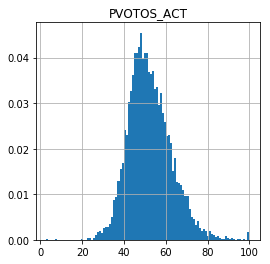

In [22]:
#Histogram of particpation
todos.hist(column=['PVOTOS_ACT'],figsize=(4,4),bins=100,density=1);

---

# Example with my village

In [23]:
sitio='Soto del Barco'

In [24]:
lugar=get_taxonomy(sitio)
lugar

{'AUTONOMIA': '03',
 'PROVINCIA': '33',
 'MUNICIPIO': '069',
 'NOMBRE': 'Soto del Barco',
 'TRAMO': '2'}

In [26]:
#Some places have tons of district within the municipality (e.g. Barcelona or Madrid)
get_distritos(lugar)

array(['00'], dtype=object)

Soto del Barco 00
03_33_069_00
Soto del Barco 00-> Abs. k, p:  1 34.74
PSOE k, p:  2 25.61
P.P. k, p:  3 12.11
PODEMOS k, p:  4 11.11
IU-IX k, p:  5 5.42
UPyD k, p:  6 2.51
F.A.C. k, p:  7 1.05
Cs k, p:  8 1.05
EB k, p:  9 0.72
PACMA k, p:  10 0.66
VOX k, p:  11 0.52
PARTIDO X 

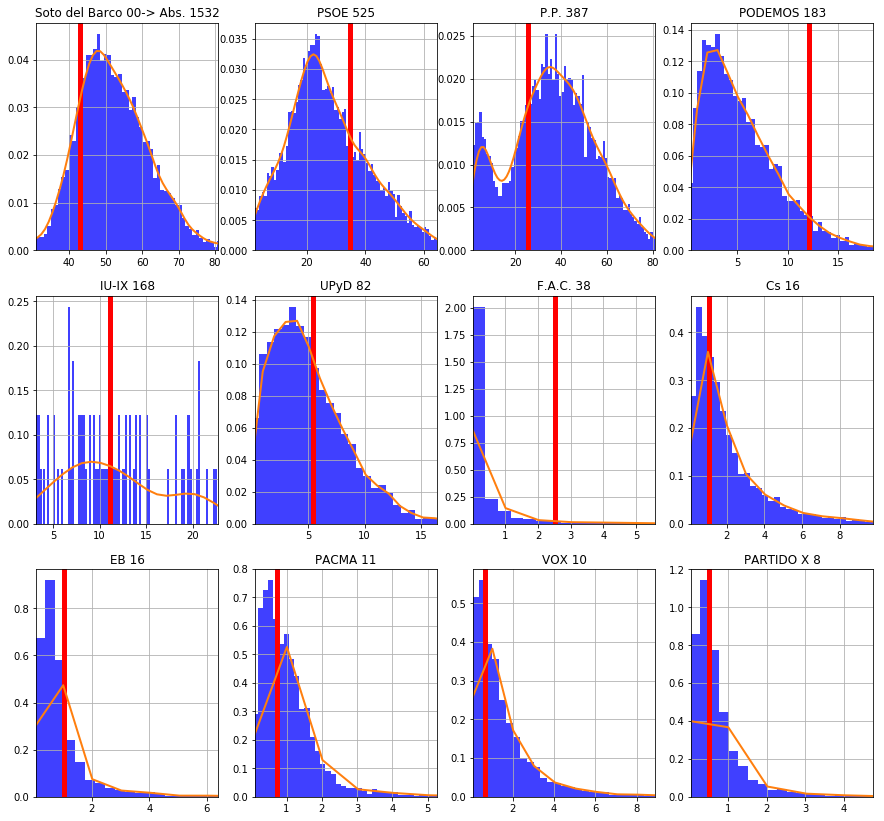

<Figure size 432x288 with 0 Axes>

In [27]:
distrito_spread(sitio,todos,distrito='00',show_plot=True ,verbose=True)

In the image above, each graph uses the same style. In blue is the national histogram, then in orange is a smoothed histogram using a gaussian kernel (this means that the integral is not 1, but it helps ientify the maximum of the histogram). In red is the value corresponding to the particular place of the graph. Top left shows the participation rate, then each row (left to right, top to bottom) shows the top 5 parties with most votes. In the titles of the grpah is the party name, and the actual value of votes for that location (not the % as the x-axis). On the x-axis, I use the range 1 to 99 percentile to have prettier graphs. The y-axis is auto-scaled to the individual range.

In [29]:
#DO SOME RANDOM PLACES, just to have bunch of graphs to scroll and get a better sense of the data quickly

#distrito_spread(sitio,distrito,get_votos_lugar(lugar),todos_votos,no_votantes,get_escrutinio_lugar(lugar))
init()
#nombres por volumen de votos
nombres=pd.read_sql_query("select distinct nombre from municipios ORDER BY RAND();",conn)[1:3]
for index,row in nombres.iterrows():
    sitio=row['nombre'] #e.g. "Valencia"
    lugar=get_taxonomy(sitio)
    distritos = get_distritos(lugar)
    for distrito in distritos:  
        distrito_spread(sitio,todos,distrito=distrito,show_plot=False,verbose=False);
        

San Salvador 00
San Salvador 00-> Abs. P.P. PSOE PODEMOS Cs VOX CCa-PNC MOVIMIENTO RED PARTIDO X LPD AGE BNG Margalef 00
Margalef 00-> Abs. CiU ERC-NECat-EPDD PSC-PSOE ICV-EUiA Cs P.P. IUA IU-IX IUC-LV IUCLM EB 

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

## GEOLOCALIZE

In order to map the municipalities, I need an extra dabase. I have the INE codes of the lotation, but not the corresponding latitude and longitude. I get that data from the the national service http://centrodedescargas.cnig.es/CentroDescargas/index.jsp

Again in some `.mdb` format.
```sh
mdb-schema --namespace geo Nomenclator_Municipios_EntidadesDePoblacion.mdb mysql > schema.sql
mkdir sql
for i in $( mdb-tables Nomenclator_Municipios_EntidadesDePoblacion.mdb ); do echo $i ; mdb-export -D "%Y-%m-%d %H:%M:%S" -H -I mysql -N geo Nomenclator_Municipios_EntidadesDePoblacion.mdb $i > sql/$i.sql; done
mysql -uroot -ppassword europeas < schema.sql
for i in $( ls sql/ ); do echo $i ; mysql -uroot -ppassword europeas < sql/$i ; done
```

I note that our results database specify two location fields, but they don't actually use them, having `0` for all cases: 
```sh
select distinct COMARCA,TRAMO from resultados;
+---------+-------+
| COMARCA | TRAMO |
+---------+-------+
| 00      | 0     |
+---------+-------+
1 row in set (0.51 sec)
```


In [32]:
#Merge the location to the results, lat-lon, but also names
init()

def get_lat_lon():
    query="select inemuni,nombre,LONGITUD_ETRS89 as lon, LATITUD_ETRS89 as lat "+\
    "from geo_ENTIDADES where tipo='Municipio';"
    geoplaces = pd.read_sql_query(query,conn)
    return geoplaces  

#provincia,municipio '02','001'
geoplaces=get_lat_lon()
geoplaces['PROVINCIA']=geoplaces['inemuni'].str.slice(start=0,stop=2)
geoplaces['MUNICIPIO']=geoplaces['inemuni'].str.slice(start=2,stop=5)

todos_geo=pd.merge(todos, geoplaces, how='inner', on=['PROVINCIA', 'MUNICIPIO'])
todos_geo

,CENSO_ACT,VOTOS_ACT,PVOTOS_ACT,PVBLAN_ACT,PVNULOS_ACT,AUTONOMIA,PROVINCIA,MUNICIPIO,DISTRITO,loc,...,p_PRAO,v_PRAO,p_Andecha Astur,v_Andecha Astur,p_BAR,v_BAR,inemuni,nombre,lon,lat
0,1110,565,50.90,2.72,2.48,01,04,001,00,01_04_001_00,...,0.00,0,0.0,0,0.0,0,04001,Abla,-2.779540,37.1412
1,1072,508,47.39,1.60,1.77,01,04,002,00,01_04_002_00,...,0.00,0,0.0,0,0.0,0,04002,Abrucena,-2.797470,37.1322
2,17411,6240,35.84,2.12,1.73,01,04,003,00,01_04_003_00,...,0.04,3,0.0,0,0.0,0,04003,Adra,-3.023300,36.7487
3,529,288,54.44,2.83,1.74,01,04,004,00,01_04_004_00,...,0.00,0,0.0,0,0.0,0,04004,Albanchez,-2.181360,37.2869
4,585,323,55.21,0.63,1.55,01,04,005,00,01_04_005_00,...,0.00,0,0.0,0,0.0,0,04005,Alboloduy,-2.621690,37.0334
5,7519,3110,41.36,2.75,1.93,01,04,006,00,01_04_006_00,...,0.00,0,0.0,0,0.0,0,04006,Albox,-2.147990,37.3885
6,767,355,46.28,1.45,2.54,01,04,007,00,01_04_007_00,...,0.00,0,0.0,0,0.0,0,04007,Alcolea,-2.960670,36.9736
7,515,322,62.52,2.22,2.17,01,04,008,00,01_04_008_00,...,0.00,0,0.0,0,0.0,0,04008,Alcóntar,-2.597570,37.3361
8,145,89,61.38,1.14,1.12,01,04,009,00,01_04_009_00,...,0.00,0,0.0,0,0.0,0,04009,Alcudia de Monteagud,-2.266790,37.2359
9,580,356,61.38,1.44,2.53,01,04,010,00,01_04_010_00,...,0.28,1,0.0,0,0.0,0,04010,Alhabia,-2.587020,36.9899


In [34]:
#computers don't like weird spanish names, sorry 
import unidecode
for col in ['nombre']:
    todos_geo[col] = todos_geo[col].apply(unidecode.unidecode)
todos_geo

,CENSO_ACT,VOTOS_ACT,PVOTOS_ACT,PVBLAN_ACT,PVNULOS_ACT,AUTONOMIA,PROVINCIA,MUNICIPIO,DISTRITO,loc,...,p_PRAO,v_PRAO,p_Andecha Astur,v_Andecha Astur,p_BAR,v_BAR,inemuni,nombre,lon,lat
0,1110,565,50.90,2.72,2.48,01,04,001,00,01_04_001_00,...,0.00,0,0.0,0,0.0,0,04001,Abla,-2.779540,37.1412
1,1072,508,47.39,1.60,1.77,01,04,002,00,01_04_002_00,...,0.00,0,0.0,0,0.0,0,04002,Abrucena,-2.797470,37.1322
2,17411,6240,35.84,2.12,1.73,01,04,003,00,01_04_003_00,...,0.04,3,0.0,0,0.0,0,04003,Adra,-3.023300,36.7487
3,529,288,54.44,2.83,1.74,01,04,004,00,01_04_004_00,...,0.00,0,0.0,0,0.0,0,04004,Albanchez,-2.181360,37.2869
4,585,323,55.21,0.63,1.55,01,04,005,00,01_04_005_00,...,0.00,0,0.0,0,0.0,0,04005,Alboloduy,-2.621690,37.0334
5,7519,3110,41.36,2.75,1.93,01,04,006,00,01_04_006_00,...,0.00,0,0.0,0,0.0,0,04006,Albox,-2.147990,37.3885
6,767,355,46.28,1.45,2.54,01,04,007,00,01_04_007_00,...,0.00,0,0.0,0,0.0,0,04007,Alcolea,-2.960670,36.9736
7,515,322,62.52,2.22,2.17,01,04,008,00,01_04_008_00,...,0.00,0,0.0,0,0.0,0,04008,Alcontar,-2.597570,37.3361
8,145,89,61.38,1.14,1.12,01,04,009,00,01_04_009_00,...,0.00,0,0.0,0,0.0,0,04009,Alcudia de Monteagud,-2.266790,37.2359
9,580,356,61.38,1.44,2.53,01,04,010,00,01_04_010_00,...,0.28,1,0.0,0,0.0,0,04010,Alhabia,-2.587020,36.9899


In [35]:
todos_geo['nombred']=todos_geo['nombre']+' '+todos_geo['DISTRITO']
todos_geo

,CENSO_ACT,VOTOS_ACT,PVOTOS_ACT,PVBLAN_ACT,PVNULOS_ACT,AUTONOMIA,PROVINCIA,MUNICIPIO,DISTRITO,loc,...,v_PRAO,p_Andecha Astur,v_Andecha Astur,p_BAR,v_BAR,inemuni,nombre,lon,lat,nombred
0,1110,565,50.90,2.72,2.48,01,04,001,00,01_04_001_00,...,0,0.0,0,0.0,0,04001,Abla,-2.779540,37.1412,Abla 00
1,1072,508,47.39,1.60,1.77,01,04,002,00,01_04_002_00,...,0,0.0,0,0.0,0,04002,Abrucena,-2.797470,37.1322,Abrucena 00
2,17411,6240,35.84,2.12,1.73,01,04,003,00,01_04_003_00,...,3,0.0,0,0.0,0,04003,Adra,-3.023300,36.7487,Adra 00
3,529,288,54.44,2.83,1.74,01,04,004,00,01_04_004_00,...,0,0.0,0,0.0,0,04004,Albanchez,-2.181360,37.2869,Albanchez 00
4,585,323,55.21,0.63,1.55,01,04,005,00,01_04_005_00,...,0,0.0,0,0.0,0,04005,Alboloduy,-2.621690,37.0334,Alboloduy 00
5,7519,3110,41.36,2.75,1.93,01,04,006,00,01_04_006_00,...,0,0.0,0,0.0,0,04006,Albox,-2.147990,37.3885,Albox 00
6,767,355,46.28,1.45,2.54,01,04,007,00,01_04_007_00,...,0,0.0,0,0.0,0,04007,Alcolea,-2.960670,36.9736,Alcolea 00
7,515,322,62.52,2.22,2.17,01,04,008,00,01_04_008_00,...,0,0.0,0,0.0,0,04008,Alcontar,-2.597570,37.3361,Alcontar 00
8,145,89,61.38,1.14,1.12,01,04,009,00,01_04_009_00,...,0,0.0,0,0.0,0,04009,Alcudia de Monteagud,-2.266790,37.2359,Alcudia de Monteagud 00
9,580,356,61.38,1.44,2.53,01,04,010,00,01_04_010_00,...,1,0.0,0,0.0,0,04010,Alhabia,-2.587020,36.9899,Alhabia 00


# Participation rate

The linchpin is to get location with less than the median of participation, so let's get it.
Also let's calculate the % change of votes of each location to that participation rate AND split that extra votes (positive or negative) among the acutal % of votes for each location, on a set of new columns, for with % delta and the acutal delta of votes.

.

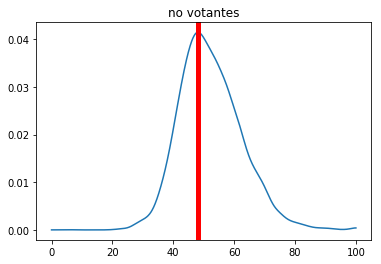

53.1


,CENSO_ACT,VOTOS_ACT,PVOTOS_ACT,PVBLAN_ACT,PVNULOS_ACT,AUTONOMIA,PROVINCIA,MUNICIPIO,DISTRITO,loc,...,d_IPEX-PREX-CREX,d_ACNV-BAR-PRAO-R.E.P.O-UNIO,d_M.C.R.,d_ACNV-R.E.P.O-UNIO,d_ANC-UNIDAD DEL PUEBLO,d_R.R.U.E.,d_Puyalon,d_PRAO,d_Andecha Astur,d_BAR
6768,2350698,1176156,50.03,1.84,1.26,12,28,079,00,12_28_079_00,...,21,14,28,0,0,0,0,0,0,0
1653,277811,101461,36.52,2.12,1.19,04,07,040,00,04_07_040_00,...,9,13,9,0,0,46,0,0,0,0
631,418011,182648,43.69,2.54,1.09,01,29,067,00,01_29_067_00,...,3,0,11,0,0,0,0,19,0,0
1696,293510,118316,40.31,2.30,1.54,05,35,016,00,05_35_016_00,...,11,22,30,0,168,0,0,0,0,0
767,543535,259044,47.66,2.45,1.30,01,41,091,00,01_41_091_00,...,2,0,11,0,0,0,0,5,0,0
166,261310,110230,42.18,3.36,1.16,01,14,021,00,01_14_021_00,...,2,0,2,0,0,0,0,8,0,0
1752,162569,61396,37.77,2.15,1.52,05,38,038,00,05_38_038_00,...,2,14,7,0,179,0,0,0,0,0
5053,1145488,583955,50.98,1.39,0.62,09,08,019,00,09_08_019_00,...,2,2,4,0,0,4,0,0,0,0
7317,274906,123759,45.02,1.85,0.85,14,48,020,00,14_48_020_00,...,13,6,6,0,0,33,0,0,0,0
1519,498233,242464,48.66,2.79,1.36,02,50,297,00,02_50_297_00,...,2,0,4,0,0,0,68,0,0,24


In [47]:
pvotos=todos_geo['PVOTOS_ACT'].values
def get_maxp(pvotos,show_plot=False,party=""):
    print(".",end="")
    if len(pvotos)==1:
        return pvotos[0]
    kde = stats.gaussian_kde(pvotos,bw_method=None) 
    nbins=1000
    t_range = np.linspace(0,100,nbins)
    pdf = kde(t_range)
    max_pdf = max(pdf)
    max_p=list(pdf).index(max_pdf)*100/nbins
    if show_plot:
        if party != "":
            plt.title(party)
        plt.plot(t_range,kde(t_range));
        plt.axvline(x=max_p,linewidth=5,color='r');
        plt.show();
    return max_p

#NOTE HERE. I´m adding a 5% buffer to make the results easier for this test run.
#This means I´m adding a 5% more participation rate so the threshold is slighlty higer than the median.

maxp_novotos=get_maxp(pvotos,show_plot=True,party='no votantes')+5
print(maxp_novotos)
todos_geo["delta_pvotos"]=0
todos_geo["delta_votos"]=0
todos_geo["delta_pvotos"]=maxp_novotos-todos_geo['PVOTOS_ACT']
todos_geo["delta_votos"]=todos_geo['CENSO_ACT']*todos_geo["delta_pvotos"]/100
todos_geo["delta_votos"]=todos_geo["delta_votos"].astype(int)

for party in filter(lambda k: 'p_' in k, todos_geo.columns):
    todos_geo["d_"+party[2:]]=todos_geo["delta_votos"]*todos_geo[party]/100.
    todos_geo["d_"+party[2:]]=todos_geo["d_"+party[2:]].astype(int)
todos_geo.sort_values('delta_votos',ascending=False)

In [37]:
#Save it all to a nifty `.csv`
todos_geo.to_csv(path_or_buf='./todos_geo-loc-names.csv',index=False)
todos_geo

,CENSO_ACT,VOTOS_ACT,PVOTOS_ACT,PVBLAN_ACT,PVNULOS_ACT,AUTONOMIA,PROVINCIA,MUNICIPIO,DISTRITO,loc,...,d_IPEX-PREX-CREX,d_ACNV-BAR-PRAO-R.E.P.O-UNIO,d_M.C.R.,d_ACNV-R.E.P.O-UNIO,d_ANC-UNIDAD DEL PUEBLO,d_R.R.U.E.,d_Puyalon,d_PRAO,d_Andecha Astur,d_BAR
0,1110,565,50.90,2.72,2.48,01,04,001,00,01_04_001_00,...,0,0,0,0,0,0,0,0,0,0
1,1072,508,47.39,1.60,1.77,01,04,002,00,01_04_002_00,...,0,0,0,0,0,0,0,0,0,0
2,17411,6240,35.84,2.12,1.73,01,04,003,00,01_04_003_00,...,0,0,1,0,0,0,0,1,0,0
3,529,288,54.44,2.83,1.74,01,04,004,00,01_04_004_00,...,0,0,0,0,0,0,0,0,0,0
4,585,323,55.21,0.63,1.55,01,04,005,00,01_04_005_00,...,0,0,0,0,0,0,0,0,0,0
5,7519,3110,41.36,2.75,1.93,01,04,006,00,01_04_006_00,...,0,0,1,0,0,0,0,0,0,0
6,767,355,46.28,1.45,2.54,01,04,007,00,01_04_007_00,...,0,0,0,0,0,0,0,0,0,0
7,515,322,62.52,2.22,2.17,01,04,008,00,01_04_008_00,...,0,0,0,0,0,0,0,0,0,0
8,145,89,61.38,1.14,1.12,01,04,009,00,01_04_009_00,...,0,0,0,0,0,0,0,0,0,0
9,580,356,61.38,1.44,2.53,01,04,010,00,01_04_010_00,...,0,0,0,0,0,0,0,0,0,0


---
# d´HONT law

According to our [legislation form the JEC](http://www.juntaelectoralcentral.es/cs/jec/loreg/contenido?packedargs=idContenido=546541&letra=S), we assing seats according to the D´Hont law.

Basically this means iterativelly assign the next seat to the party with more votes, and then divide those parties votes with the total number of votes they got so far. There are some edge cases where the votes are the same, but do not apply here. 

Note: Most cases that apply this rule also impose a minimum threshold of votes. This is not the case for Spain and the Euopean elections (It will be after 2024, with a 3% of the total census). 

In [42]:
def dhont(nSeats,votes,verbose=False):
    """
    nSeats is the number of seats
    votes is a dictionary with the key:value {'party':votes}
    verbose is an option to print designation info
    """
    t_votes=votes.copy()
    seats={}
    for key in votes: seats[key]=0
    while sum(seats.values()) < nSeats:
        max_v= max(t_votes.values())
        next_seat=list(t_votes.keys())[list(t_votes.values()).index(max_v)]
        if next_seat in seats:
            seats[next_seat]+=1
        else:
            seats[next_seat]=1
        
        if verbose:
            print("{} Escaño: {}".format(sum(seats.values()),next_seat))
            for key in t_votes: 
                print("\t{:4.4} [{}]:\t {:.1f}".format(key,seats[key],t_votes[key]))
            print("\b")
        t_votes[next_seat]=votes[next_seat]/(seats[next_seat]+1)
    for key in votes: 
        if seats[key]==0:
            del seats[key]
        #print(t_votes)
    return seats
nSeats = 54

#Test using the exact official votes for the European elections
votes = {'P.P.':4098339,'PSOE':3614232,'IP':1575308,'Podemos':1253837,'UPYD':1022232,'CEU':851971,
        'EPDD':630072,"Cs":497146,"LDP":326464,'EP':302266,'VOX':246833}
seats=dhont(nSeats,votes,verbose=False)
seats

{'P.P.': 16,
 'PSOE': 14,
 'IP': 6,
 'Podemos': 5,
 'UPYD': 4,
 'CEU': 3,
 'EPDD': 2,
 'Cs': 2,
 'LDP': 1,
 'EP': 1}

# Example with my village



In [43]:
place='Soto del Barco 00'
for a in todos_geo[todos_geo['nombred']==place].columns:
    print(a,todos_geo[todos_geo['nombred']==place][a].values)


CENSO_ACT [3575]
VOTOS_ACT [1532]
PVOTOS_ACT [42.85]
PVBLAN_ACT [1.46]
PVNULOS_ACT [1.37]
AUTONOMIA ['03']
PROVINCIA ['33']
MUNICIPIO ['069']
DISTRITO ['00']
loc ['03_33_069_00']
p_P.P. [25.61]
v_P.P. [387]
p_PSOE [34.74]
v_PSOE [525]
p_PODEMOS [12.11]
v_PODEMOS [183]
p_UPyD [5.42]
v_UPyD [82]
p_Cs [1.05]
v_Cs [16]
p_ERC-NECat-EPDD [0.]
v_ERC-NECat-EPDD [0]
p_CiU [0.]
v_CiU [0]
p_LA IZQUIERDA PLURAL [0.]
v_LA IZQUIERDA PLURAL [0]
p_PRIMAVERA EUROPEA [0.39]
v_PRIMAVERA EUROPEA [6]
p_PSC-PSOE [0.]
v_PSC-PSOE [0]
p_VOX [0.66]
v_VOX [10]
p_IULV-CA [0.]
v_IULV-CA [0]
p_CEU [0.]
v_CEU [0]
p_ICV-EUiA [0.]
v_ICV-EUiA [0]
p_IU-LV [0.]
v_IU-LV [0]
p_PACMA [0.72]
v_PACMA [11]
p_EPDD [0.]
v_EPDD [0]
p_EH Bildu [0.]
v_EH Bildu [0]
p_EAJ-PNV [0.]
v_EAJ-PNV [0]
p_EUPV-EV [0.]
v_EUPV-EV [0]
p_EB [1.05]
v_EB [16]
p_MOVIMIENTO RED [0.46]
v_MOVIMIENTO RED [7]
p_PARTIDO X [0.52]
v_PARTIDO X [8]
p_LPD [0.]
v_LPD [0]
p_AGE [0.]
v_AGE [0]
p_BNG [0.]
v_BNG [0]
p_IUCyL [0.]
v_IUCyL [0]
p_CCa-PNC [0.]
v_CCa-PNC

In [45]:
#print a selection of columns, to explore the data.
partido="PODEMOS"
cols=['PVOTOS_ACT','CENSO_ACT','nombred','delta_pvotos','delta_votos','p_'+partido,'v_'+partido,'d_'+partido]
todos_geo[(todos_geo['PVOTOS_ACT']<maxp_novotos)][cols].sort_values(by='p_'+partido,ascending=False)


,PVOTOS_ACT,CENSO_ACT,nombred,delta_pvotos,delta_votos,p_PODEMOS,v_PODEMOS,d_PODEMOS
4404,46.88,64,Ausejo de la Sierra 00,6.22,3,30.00,9,0
6759,51.92,52,La Hiruela 00,1.18,0,29.62,8,0
4080,50.69,144,San Pedro del Valle 00,2.41,3,27.39,20,0
4428,50.00,22,Carrascosa de la Sierra 00,3.10,0,27.27,3,0
4354,43.33,30,Valdevacas de Montejo 00,9.77,2,25.00,3,0
2167,42.35,85,Masegosa 00,10.75,9,25.00,9,2
4387,44.44,18,Aldealpozo 00,8.66,1,25.00,2,0
6910,49.28,69,Aranarache/Aranaratxe 00,3.82,2,23.52,8,0
3031,44.44,99,Zapardiel de la Ribera 00,8.66,8,23.25,10,1
3281,45.16,62,Rojas 00,7.94,4,23.07,6,0


In [48]:
"""
Now that the all the data is done, let´s select the places with less participation than the threshold
"""
#2 Filtrar donde novotos < maxp
potenciales_no = todos_geo[(todos_geo['PVOTOS_ACT']<maxp_novotos)]
print("{} ({:.0f}%) lugares por debajo de la media de {}% de participación, que suman {} votos extra".format(len(potenciales_no),
                                                len(potenciales_no)/len(todos_geo)*100,
                                                maxp_novotos,potenciales_no['delta_votos'].sum()))
partido='PODEMOS'
cols=['PVOTOS_ACT','CENSO_ACT','nombred','delta_pvotos','delta_votos','p_'+partido,'v_'+partido,'d_'+partido]
potenciales_no[cols].sort_values(by='d_'+partido,ascending=False)


4646 (57%) lugares por debajo de la media de 53.1% de participación, que suman 2856320 votos extra


,PVOTOS_ACT,CENSO_ACT,nombred,delta_pvotos,delta_votos,p_PODEMOS,v_PODEMOS,d_PODEMOS
6768,50.03,2350698,Madrid 00,3.07,72166,10.45,121428,7541
1696,40.31,293510,Las Palmas de Gran Canaria 00,12.79,37539,16.40,19109,6156
1653,36.52,277811,Palma 00,16.58,46061,11.84,11874,5453
631,43.69,418011,Malaga 00,9.41,39334,9.46,17096,3720
767,47.66,543535,Sevilla 00,5.44,29568,9.75,24929,2882
1752,37.77,162569,Santa Cruz de Tenerife 00,15.33,24921,10.34,6255,2576
121,39.89,164456,Jerez de la Frontera 00,13.21,21724,11.81,7664,2565
7425,39.42,150727,Cartagena 00,13.68,20619,12.20,7120,2515
1579,43.61,179225,Oviedo 00,9.49,17008,14.62,11277,2486
1519,48.66,498233,Zaragoza 00,4.44,22121,10.96,26218,2424


In [49]:
"""
This cell uses a bit a brute force approach to get quicker results.
Basically it takes a random sample of 100 or 120 places that are within the low participation threshold,
then it calulate the electoral results adding the extra votes, keeping the % of votes for each location where the
participation is increased. Then it also calculates the seats according th D´Hont.
It iterates this random sample 5.000 times until it finds a combination of places that yield more seats for the 
selected party.
It also selected places with at least 100 votes for our selected party.
"""
def get_escrutinio(places,deltas=None):
    escrutinio={}
    for party in filter(lambda k: 'v_' in k, places.columns):
        if isinstance(deltas, pd.DataFrame):
            escrutinio[party[2:]]=places[party].sum()+deltas['d_'+party[2:]].sum()
        else:
            escrutinio[party[2:]]=places[party].sum()
    return escrutinio

partido="PODEMOS"
potenciales_no = todos_geo[(todos_geo['PVOTOS_ACT']<maxp_novotos)]
potenciales_no=potenciales_no[(potenciales_no['d_'+partido]>100)]
print(len(potenciales_no))
nSeats = 54
max_seats=0
max_sample=potenciales_no
baseline=dhont(nSeats,get_escrutinio(todos_geo),verbose=False)[partido]
target=baseline+1
i=0
for n in [100,120]:
    for t in range(5000):
        i+=1
        deltas=potenciales_no.sample(n)
        escrutinio=get_escrutinio(todos_geo,deltas=deltas)
        seats=dhont(nSeats,escrutinio,verbose=False)
        if seats[partido]>max_seats:
            max_seats=seats[partido]
            max_sample=deltas
            print('{} tries. New max {} seats with {} places. Baseline {}  \n'.format(i,max_seats,len(deltas),baseline),end='\r')
        print("{} tries. {} seats with {} places. Baseline {}  ".format(i,max_seats,len(deltas),baseline),end='\r')
print("")
print(seats)
cols=['PVOTOS_ACT','nombred','delta_pvotos','delta_votos','p_'+partido,'v_'+partido,'d_'+partido]
max_sample[cols]

417
1 tries. New max 5 seats with 100 places. Baseline 5  
5115 tries. New max 6 seats with 120 places. Baseline 5  
10000 tries. 6 seats with 120 places. Baseline 5  
{'P.P.': 19, 'PSOE': 14, 'PODEMOS': 5, 'UPyD': 4, 'Cs': 2, 'ERC-NECat-EPDD': 2, 'CiU': 2, 'PRIMAVERA EUROPEA': 1, 'PSC-PSOE': 1, 'VOX': 1, 'IULV-CA': 1, 'ICV-EUiA': 1, 'IU-LV': 1}


,PVOTOS_ACT,nombred,delta_pvotos,delta_votos,p_PODEMOS,v_PODEMOS,d_PODEMOS
6764,48.77,Leganes 00,4.33,5989,15.19,10076,909
7717,44.89,Mutxamel 00,8.21,1411,9.32,704,131
1682,40.05,Aguimes 00,13.05,2995,15.54,1410,465
322,44.02,Maracena 00,9.08,1477,7.91,556,116
8093,48.37,Paterna 00,4.73,2313,8.83,2058,204
5063,50.20,Barcelona 10,2.90,4849,5.60,4675,271
1608,30.10,Tineo 00,23.00,2050,7.72,203,158
1624,34.27,Calvia 00,18.83,5728,9.12,942,522
1595,44.81,San Martin del Rey Aurelio 00,8.29,1254,12.67,841,158
6074,39.95,Merida 00,13.15,6015,6.71,1207,403


In [50]:
max_sample.to_csv(path_or_buf='./podemos-5-150.csv',index=False)


In [52]:
dhont(nSeats,get_escrutinio(todos_geo),verbose=False)
deltas=todos_geo.sample(1)
deltas['d_PODEMOS']=25000
deltas
print(dhont(nSeats,get_escrutinio(todos_geo),verbose=False))
print(dhont(nSeats+1,get_escrutinio(todos_geo),verbose=False))
dhont(nSeats,get_escrutinio(todos_geo,deltas=deltas),verbose=False)

{'P.P.': 19, 'PSOE': 14, 'PODEMOS': 5, 'UPyD': 4, 'Cs': 2, 'ERC-NECat-EPDD': 2, 'CiU': 2, 'PRIMAVERA EUROPEA': 1, 'PSC-PSOE': 1, 'VOX': 1, 'IULV-CA': 1, 'ICV-EUiA': 1, 'IU-LV': 1}
{'P.P.': 19, 'PSOE': 14, 'PODEMOS': 6, 'UPyD': 4, 'Cs': 2, 'ERC-NECat-EPDD': 2, 'CiU': 2, 'PRIMAVERA EUROPEA': 1, 'PSC-PSOE': 1, 'VOX': 1, 'IULV-CA': 1, 'ICV-EUiA': 1, 'IU-LV': 1}


{'P.P.': 18,
 'PSOE': 14,
 'PODEMOS': 6,
 'UPyD': 4,
 'Cs': 2,
 'ERC-NECat-EPDD': 2,
 'CiU': 2,
 'PRIMAVERA EUROPEA': 1,
 'PSC-PSOE': 1,
 'VOX': 1,
 'IULV-CA': 1,
 'ICV-EUiA': 1,
 'IU-LV': 1}

In [53]:
conn.close()